# STA 141B Project Group 12

Completed work of all members for the group project

### Duy's Section

In [2]:
import requests
import pandas as pd
import time
import lxml.html as lx

In [4]:
url = 'https://www.cheapshark.com/api/1.0/deals' 

In [7]:
test_set = pd.DataFrame() # Testing 
for i in range(1, 2):
    result = requests.get(url, params= {
    'storeID' : 1,
    'pageNumber' : i,
    'AAA' : 1
    })

    data = result.json()
    data = pd.DataFrame(data)

    test_set = pd.concat([test_set, data], ignore_index=True)

    time.sleep(2)

In [5]:
full_set = pd.DataFrame() # It's named that way but is actually just used for making the indie set
for i in range(1, 51):
    result = requests.get(url, params= {
    'storeID' : 1,
    'pageNumber' : i
    })

    data = result.json()
    data = pd.DataFrame(data)

    full_set = pd.concat([full_set, data], ignore_index=True)

    time.sleep(2)

full_set = full_set[["title", "steamAppID", "releaseDate", "normalPrice", "metacriticScore", "steamRatingText", "steamRatingPercent"]]

In [11]:
aaa_set = pd.DataFrame()
for i in range(1, 46): # Putting in AAA parameter limits the max pages down to 50 for some reason
    result = requests.get(url, params= {
    'storeID' : 1,
    'pageNumber' : i,
    'AAA' : 1
    })

    data = result.json()
    data = pd.DataFrame(data)

    aaa_set = pd.concat([aaa_set, data], ignore_index=True)

    time.sleep(2)

aaa_set = aaa_set[["title", "steamAppID", "releaseDate", "normalPrice", "metacriticScore", "steamRatingText", "steamRatingPercent"]]

In [12]:
aaa_set["normalPrice"] = aaa_set["normalPrice"].astype(float)
aaa_set["metacriticScore"] = aaa_set["metacriticScore"].astype(int)
aaa_set["steamRatingPercent"] = aaa_set["steamRatingPercent"].astype(int)
aaa_set = aaa_set[aaa_set["metacriticScore"] > 0]
aaa_set = aaa_set[aaa_set["normalPrice"] < 70] # API has some errors address this in markdown

In [6]:
full_set["normalPrice"] = full_set["normalPrice"].astype(float)
full_set["metacriticScore"] = full_set["metacriticScore"].astype(int)
full_set["steamRatingPercent"] = full_set["steamRatingPercent"].astype(int)
#type(full_set["normalPrice"][1])

In [7]:
#aaa_set = full_set[full_set["normalPrice"] >= 29]
indie_set = full_set[full_set["normalPrice"] < 29] # No way to parse for normal price on the API, alternative method is this
indie_set = indie_set[indie_set["metacriticScore"] > 0] # To account for missing metacritic

In [ ]:
#html_page.xpath('//a[@class="tab_item_overlay"]/@href')[0]

In [30]:
### STEAM SCRAPING WORK DO NOT RUN ONLY FOR TESTING PURPOSES
steam_base = 'https://store.steampowered.com/search/?term='
steam = requests.get(steam_base + "Modern+Warfare+3")


html = lx.fromstring(steam.text)
game_store = html.xpath('//div[@id="search_resultsRows"]//a/@href')[0]
steam_page = requests.get(game_store)
html_page = lx.fromstring(steam_page.text)
#html_page.xpath('//a[@class="tab_item_overlay"]/@href')[0]
dev = str(html_page.xpath('//div[@id="developers_list"]//a/text()')[0])
pub = html_page.xpath('//div[@class="summary column"]//a/text()')
pub = str(pub[len(pub) - 1])


In [8]:
def get_authors(search_title): #Real final function code
    steam_base = 'https://store.steampowered.com/search/?term=' #BACKUP
    developers = []
    publishers = []

    for titles in search_title:
        steam = requests.get(steam_base + titles)
        html = lx.fromstring(steam.text)
        try: # Cheapshark API sometimes makes errors. There is no way to automatically fix the query
            # Instead, just set them to broken
            game_store = html.xpath('//div[@id="search_resultsRows"]//a/@href')[0]
        except:
            developers.append("BROKEN_ERROR")
            publishers.append("BROKEN_ERROR")
            continue

        steam_page = requests.get(game_store)
        html_page = lx.fromstring(steam_page.text)
        try:
            dev = str(html_page.xpath('//div[@id="developers_list"]//a/text()')[0])
            pub = html_page.xpath('//div[@class="summary column"]//a/text()')
            pub = str(pub[len(pub) - 1])
        except: # In the event it leads to a bundle for some reason
            try: 
                game_store = html_page.xpath('//a[@class="tab_item_overlay"]/@href')[0]
                steam_page = requests.get(game_store)
                html_page = lx.fromstring(steam_page.text)
                dev = str(html_page.xpath('//div[@id="developers_list"]//a/text()')[0])
                pub = html_page.xpath('//div[@class="summary column"]//a/text()')
                pub = str(pub[len(pub) - 1])
            except: # IN THE EVENT IT WAS DUE TO THERE BEING NO DEVELOPER
                game_store = html.xpath('//div[@id="search_resultsRows"]//a/@href')[0]
                steam_page = requests.get(game_store)
                html_page = lx.fromstring(steam_page.text)

                try:
                    dev = str(html_page.xpath('//div[@id="developers_list"]//a/text()')[0])
                    #pub = html_page.xpath('//div[@class="summary column"]//a/text()')
                    #pub = str(pub[len(pub) - 1])
                except: 
                    try:
                        dev = "BROKEN_ERROR"
                        pub = html_page.xpath('//div[@class="summary column"]//a/text()')
                        pub = str(pub[len(pub) - 1])
                    except:
                        developers.append("BROKEN_ERROR")
                        publishers.append("BROKEN_ERROR")
                        continue


        developers.append(dev)
        publishers.append(pub)
        
        #time.sleep(1)
    authors = pd.DataFrame({'developers' : developers, 'publishers' : publishers})
    return authors

In [44]:
search_title = [title.replace(" ", "+").replace("!", "").replace("?", "") for title in indie_set["title"]][0: 100]


In [9]:
search_title = [title.replace(" ", "+").replace("!", "").replace("?", "") for title in indie_set["title"]]
indie_authors = get_authors(search_title) # Function do not run if data is already available

In [10]:
indie_set = indie_set.reset_index(drop = True)
indie_set = pd.concat([indie_set, indie_authors], axis = 1)

In [13]:
search_title = [title.replace(" ", "+").replace("!", "").replace("?", "") for title in aaa_set["title"]] #AAA
aaa_authors = get_authors(search_title)

In [14]:
aaa_set = aaa_set.reset_index(drop = True)
aaa_set = pd.concat([aaa_set, aaa_authors], axis = 1)

In [17]:
aaa_set.to_csv('aaa_set.csv', index = False)
indie_set.to_csv('indie_set.csv', index= False) #Zhanyi's code to include additional columns are in his section.

### JUDAH SECTION

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#### Conversion of datetime from unix to YY-MM-DD

In [ ]:
full_set['releaseDate'] = pd.to_datetime(full_set['releaseDate'], unit='s').dt.date
aaa_set['releaseDate'] = pd.to_datetime(aaa_set['releaseDate'], unit='s').dt.date
indie_set['releaseDate'] = pd.to_datetime(indie_set['releaseDate'], unit='s').dt.date

In [2]:
aaa_csv_df = pd.read_csv('/Users/judahhsu/Desktop/Classes/STA 141B/update_aaa_set.csv')
indie_csv_df = pd.read_csv('/Users/judahhsu/Desktop/Classes/STA 141B/update_indie_set.csv')

#### Plots

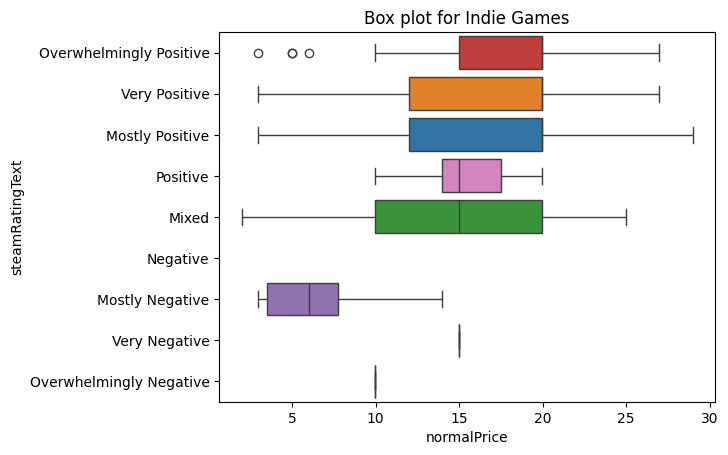

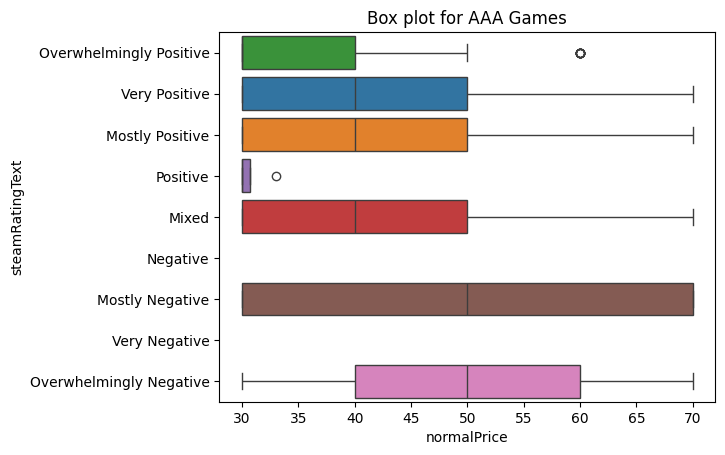

In [5]:
#Box Plots between steam rating text and normal price
ratingOrder = ['Overwhelmingly Positive', 'Very Positive', 'Mostly Positive', 'Positive', 'Mixed', 
              'Negative', 'Mostly Negative', 'Very Negative', 'Overwhelmingly Negative']

#Basic boxplot: Rating texts on normal price, for indie
sns.boxplot(x='normalPrice', y='steamRatingText', data=indie_csv_df, hue='steamRatingText', 
            order=ratingOrder, legend=False)
plt.title('Box plot for Indie Games')
plt.show()

#Basic boxplot: Rating texts on normal price, for aaa
sns.boxplot(x='normalPrice', y='steamRatingText', data=aaa_csv_df, hue= 'steamRatingText', 
            order=ratingOrder, legend=False)
plt.title('Box plot for AAA Games')
plt.show()


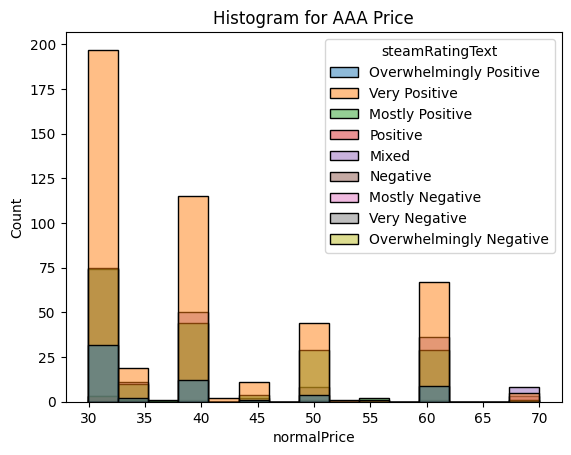

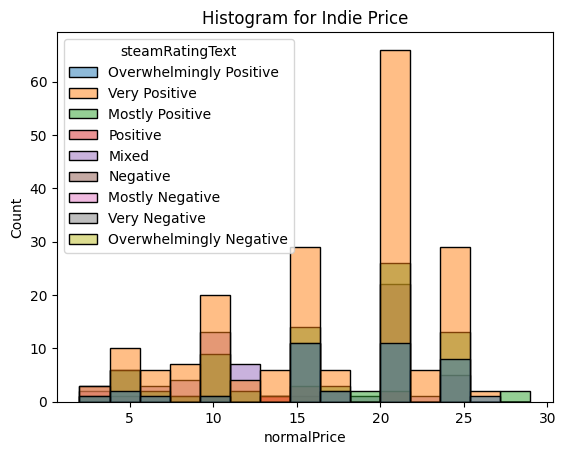

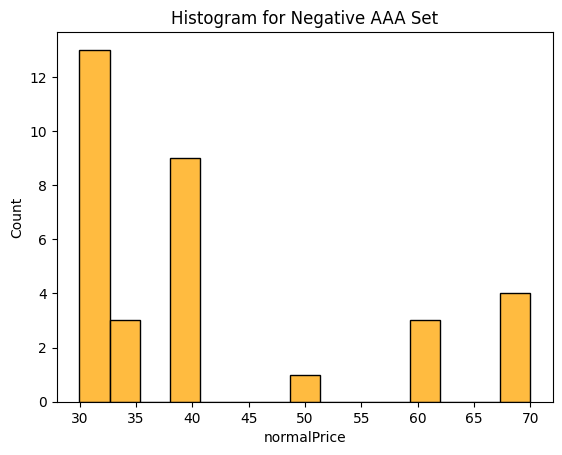

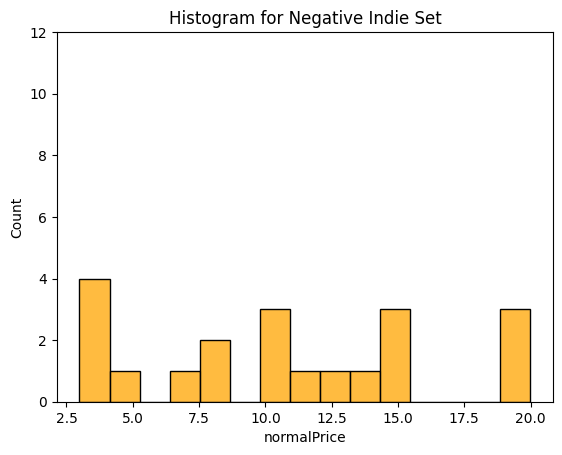

In [9]:
#Histograms for normal price according to steam rating text
sns.histplot(data=aaa_csv_df, x='normalPrice', bins=15, hue='steamRatingText', hue_order=ratingOrder)
plt.title("Histogram for AAA Price")
plt.show()

sns.histplot(data=indie_csv_df, x='normalPrice', bins=15, hue='steamRatingText', hue_order=ratingOrder)
plt.title("Histogram for Indie Price")
plt.show()

aaa_csv_df['Sentiment'] = 'Neutral'  
aaa_csv_df.loc[aaa_csv_df['positive_reviews'] > aaa_csv_df['negative_reviews'], 'Sentiment'] = 'Positive'
aaa_csv_df.loc[aaa_csv_df['positive_reviews'] < aaa_csv_df['negative_reviews'], 'Sentiment'] = 'Negative'
aaa_neg = aaa_csv_df[aaa_csv_df['Sentiment'] == 'Negative']

indie_csv_df['Sentiment'] = 'Neutral' 
indie_csv_df.loc[indie_csv_df['positive_reviews'] > indie_csv_df['negative_reviews'], 'Sentiment'] = 'Positive'
indie_csv_df.loc[indie_csv_df['positive_reviews'] < indie_csv_df['negative_reviews'], 'Sentiment'] = 'Negative'
indie_neg = indie_csv_df[indie_csv_df['Sentiment'] == 'Negative']

sns.histplot(data = aaa_neg, x = 'normalPrice', bins=15, color='orange')
plt.title('Histogram for Negative AAA Set')
plt.show()
ax = sns.histplot(data = indie_neg, x = 'normalPrice', bins=15, color='orange')
plt.title('Histogram for Negative Indie Set')
ax.set_yticks([0, 2, 4, 6, 8, 10, 12])
plt.show()

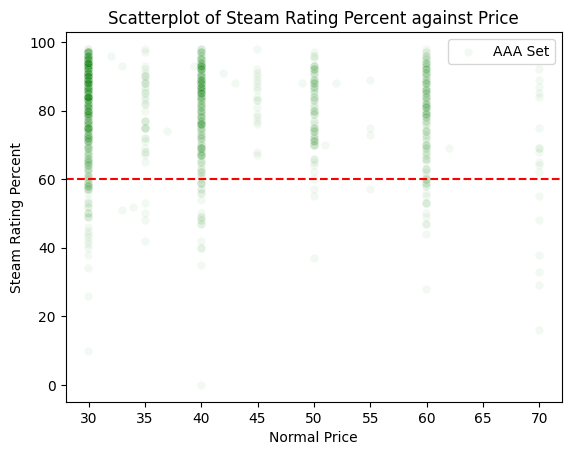

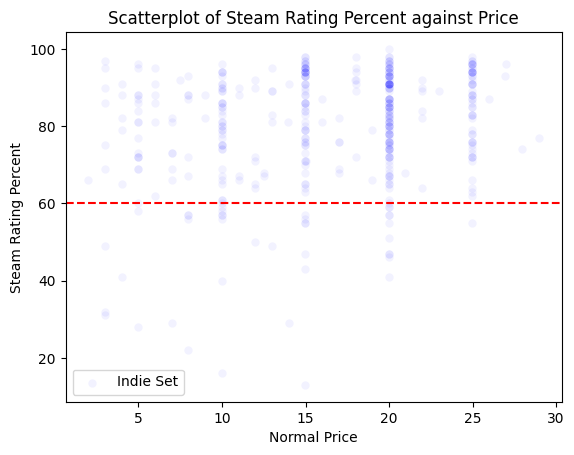

In [10]:
#Scatterplot of Steam Rating Percent against Price
sns.scatterplot(data = aaa_csv_df, x='normalPrice', y='steamRatingPercent', alpha = 0.05, color='green',
               label='AAA Set')
plt.xlabel('Normal Price')
plt.ylabel('Steam Rating Percent')
plt.axhline(y=60, color='red', linestyle= '--')
plt.title('Scatterplot of Steam Rating Percent against Price')
plt.show()

sns.scatterplot(data = indie_csv_df, x='normalPrice', y='steamRatingPercent', alpha = 0.05, color='blue',
               label='Indie Set')
plt.xlabel('Normal Price')
plt.ylabel('Steam Rating Percent')
plt.axhline(y=60, color='red', linestyle= '--')
plt.title('Scatterplot of Steam Rating Percent against Price')
plt.show()

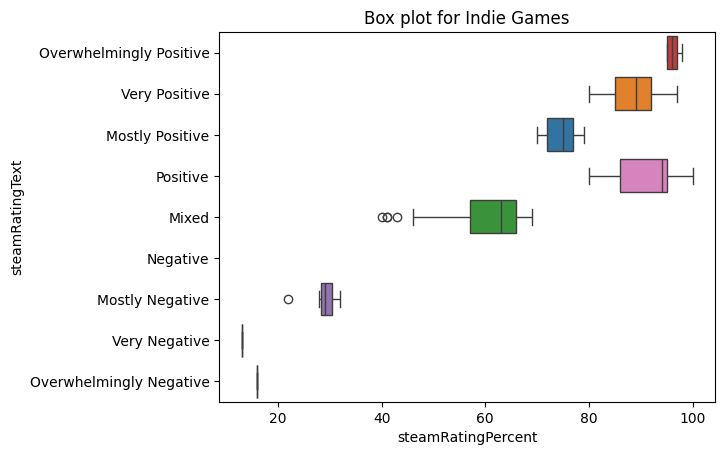

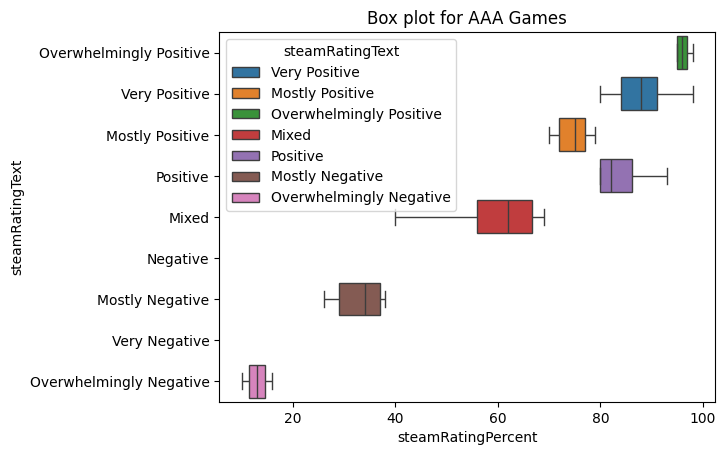

In [12]:
#Box plot between Steam Rating Percent and Steam Rating Text
#This is not included in the report
sns.boxplot(x='steamRatingPercent', y='steamRatingText', data=indie_csv_df, hue='steamRatingText', 
            order=ratingOrder)
plt.title('Box plot for Indie Games')
plt.show()


sns.boxplot(x='steamRatingPercent', y='steamRatingText', data=aaa_csv_df, hue= 'steamRatingText', 
            order=ratingOrder)
plt.title('Box plot for AAA Games')
plt.show()

In [ ]:
#GIF 

import numpy as np
import imageio

years = sorted(indie_csv_df["releaseDate"].str[:4].astype(int).unique())
def render_frame(year, data, set):
    """Render a single frame (plot) in an animated visualization.
    
    Adapted from: https://ndres.me/post/matplotlib-animated-gifs-easily/
    """
    fig = plt.figure(figsize = (10, 5))
    
    data_subset = data[data["releaseDate"].str[:4].astype(int) == year]
    ax = sns.scatterplot(x = "normalPrice", y = "steamRatingPercent", data = data_subset)
    ax.set_title(f'{year}')
    ax.set_xlabel(f"Normal Price of {set} Games")
    ax.set_ylabel("Steam Rating Percent")
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)


    # Draw the figure and then convert it to a Numpy array.
    fig.canvas.draw()
    
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype = "uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    # Close the matplotlib figure (we're done with it)
    plt.close()
    return image
plots = [render_frame(y, indie_csv_df, 'indie') for y in years]

imageio.mimsave("reviewDatesIndie.gif", plots, fps = 20) # Save a list of images as a GIF file.

#------------------------------------------------


years = sorted(aaa_csv_df["releaseDate"].str[:4].astype(int).unique())
plots = [render_frame(y, aaa_csv_df, 'indie') for y in years]

imageio.mimsave("reviewDatesIndie.gif", plots, fps = 20) # Save a list of images as a GIF file.

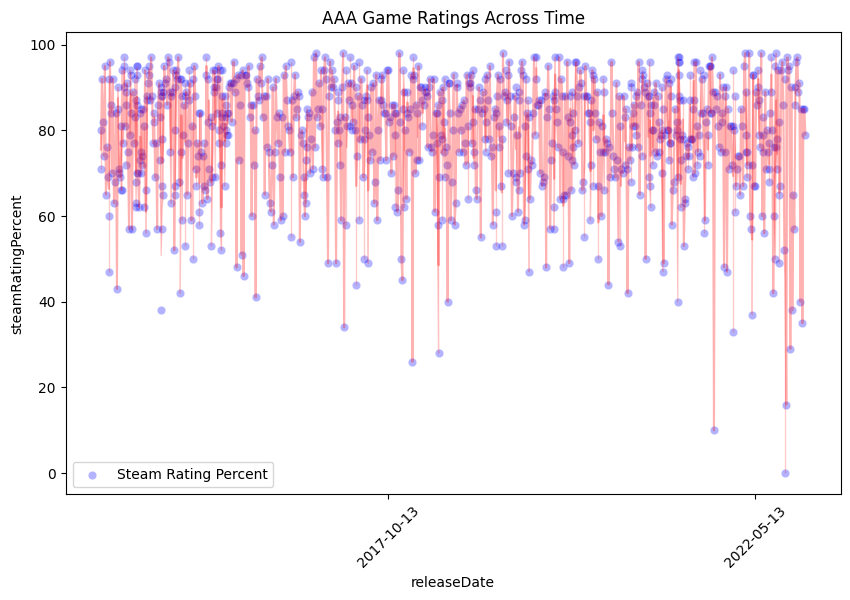

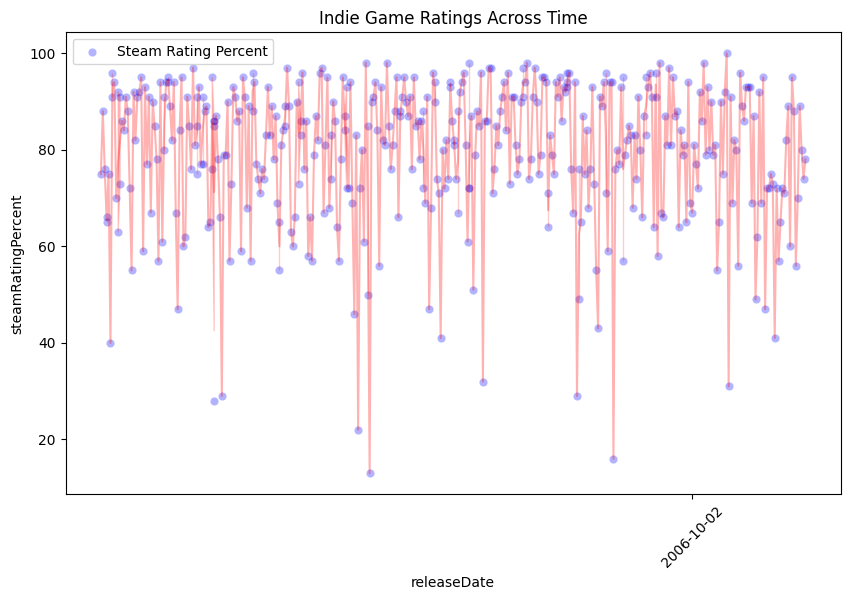

In [13]:
#These are not included in the report
#Time data of steam rating percents over time
plt.figure(figsize=(10,6))
sns.scatterplot(x= 'releaseDate', y = 'steamRatingPercent', data = aaa_csv_df, label = 'Steam Rating Percent', color = 'blue', alpha=0.3)
sns.lineplot(x='releaseDate', y='steamRatingPercent', data = aaa_csv_df, 
             color='red', alpha = 0.3)

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=365)) 
plt.title("AAA Game Ratings Across Time")
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x= 'releaseDate', y = 'steamRatingPercent', data = indie_csv_df, label = 'Steam Rating Percent', color = 'blue', alpha=0.3)
sns.lineplot(x='releaseDate', y='steamRatingPercent', data = indie_csv_df, 
             color='red', alpha = 0.3)

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=365)) 
plt.title("Indie Game Ratings Across Time")
plt.show()

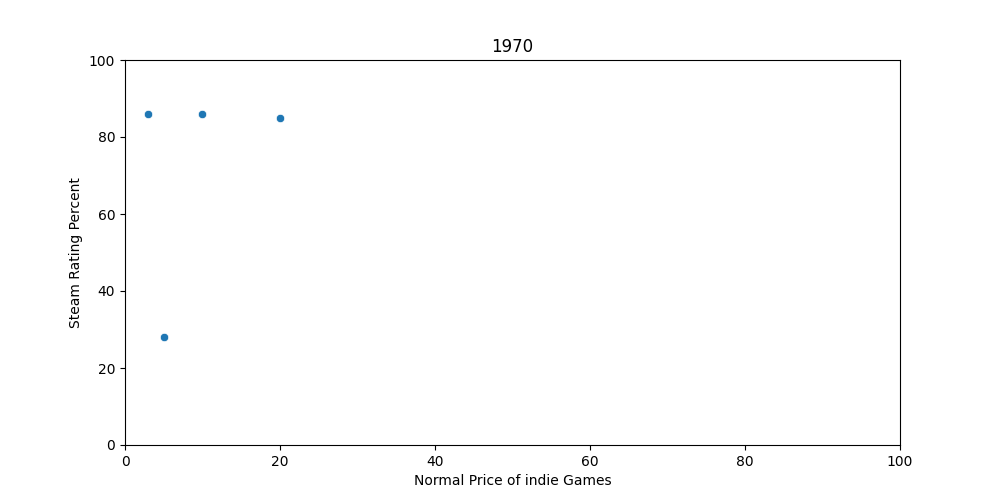

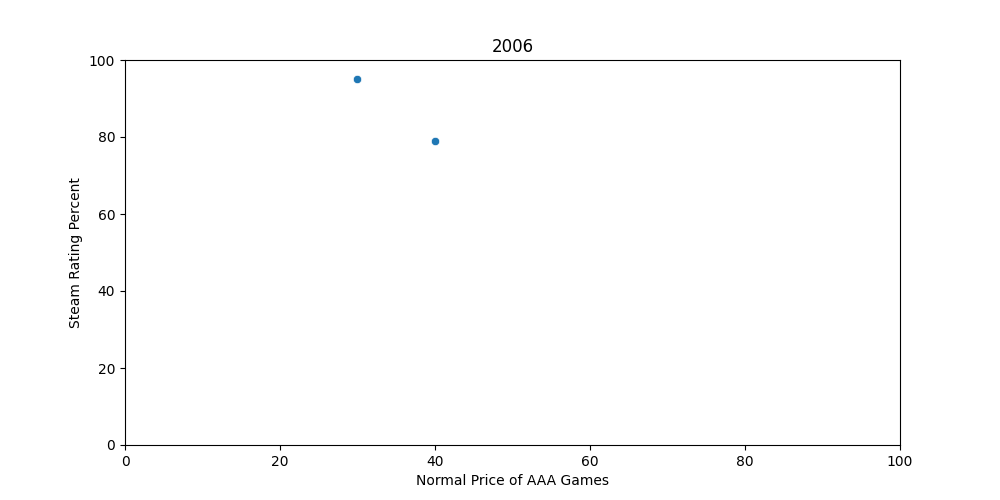

In [17]:
from IPython.display import display, Image

display(Image(filename='indie_fr25.gif'))
display(Image(filename='aaa_fr25.gif'))

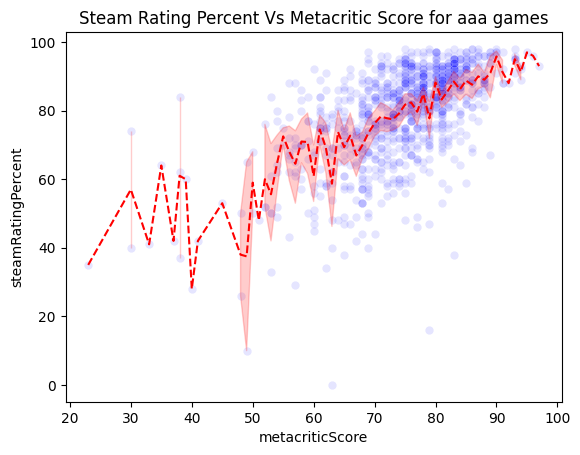

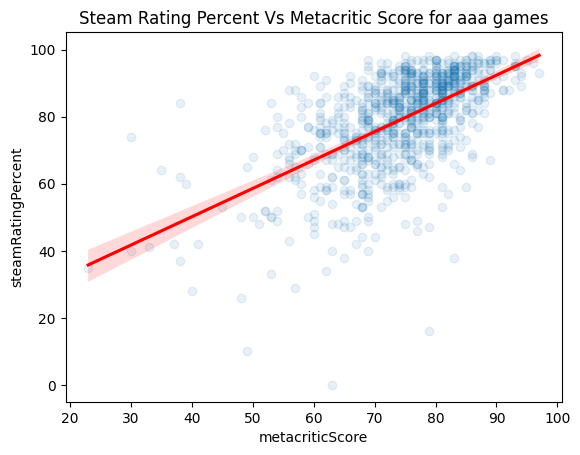

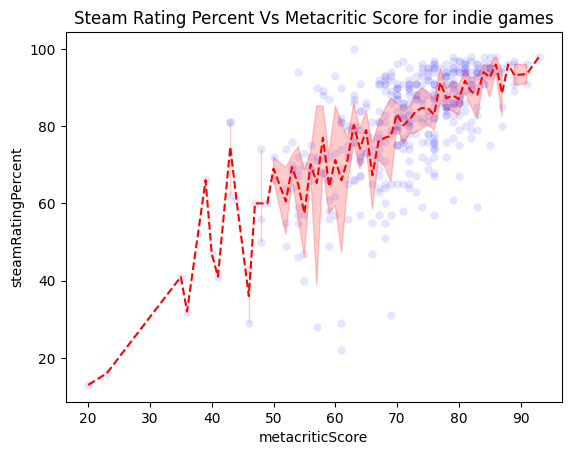

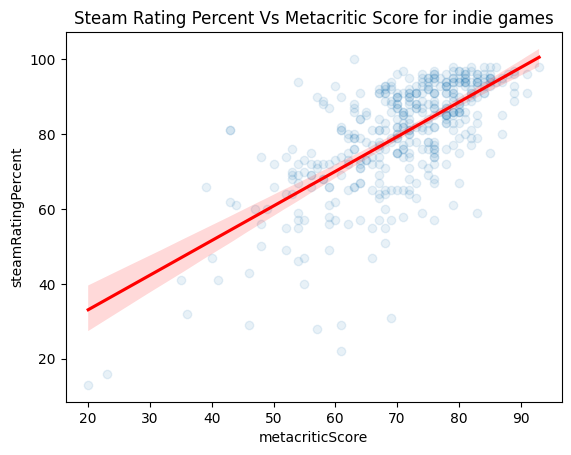

In [14]:
#Scatterplot between metacritic and steamratingpercent
def show_scatterplot(data, title_name):
    sns.scatterplot(data=data, x='metacriticScore', y='steamRatingPercent', alpha=0.1, color='blue')
    sns.lineplot(data=data, x='metacriticScore', y='steamRatingPercent', color='red', linestyle='--')
    plt.title(f'Steam Rating Percent Vs Metacritic Score for {title_name}')
    
    plt.show()
    sns.regplot(data=data, x='metacriticScore', y='steamRatingPercent', 
            scatter_kws={'alpha':0.1},
            line_kws={'color':'red'}
               )
    plt.title(f'Steam Rating Percent Vs Metacritic Score for {title_name}')
    plt.show()

show_scatterplot(aaa_csv_df, "aaa games")
show_scatterplot(indie_csv_df, 'indie games')

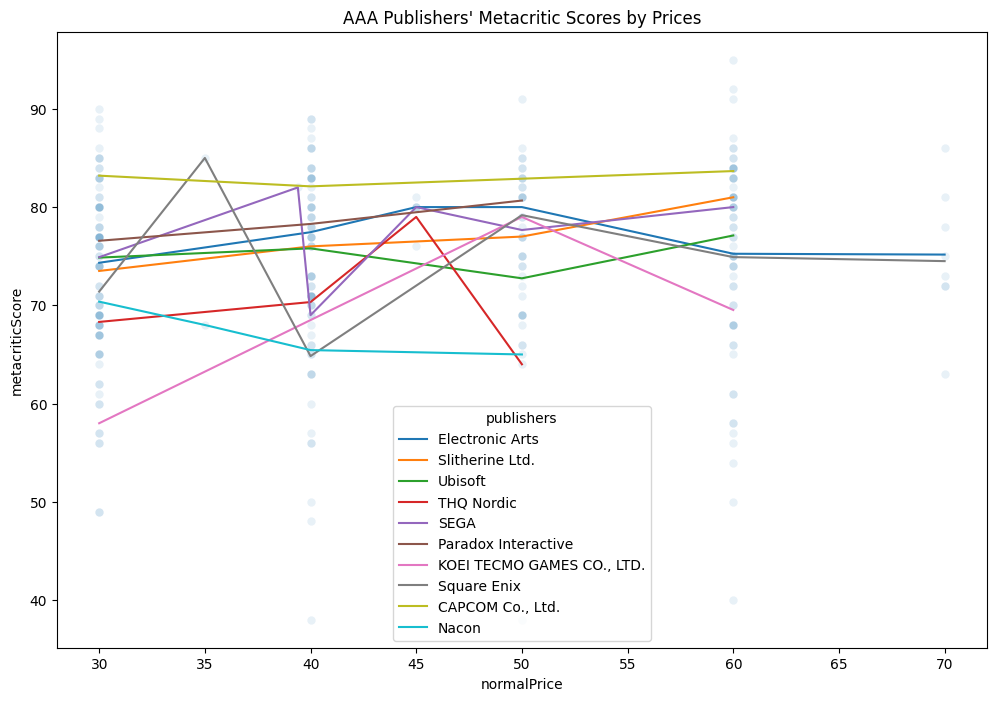

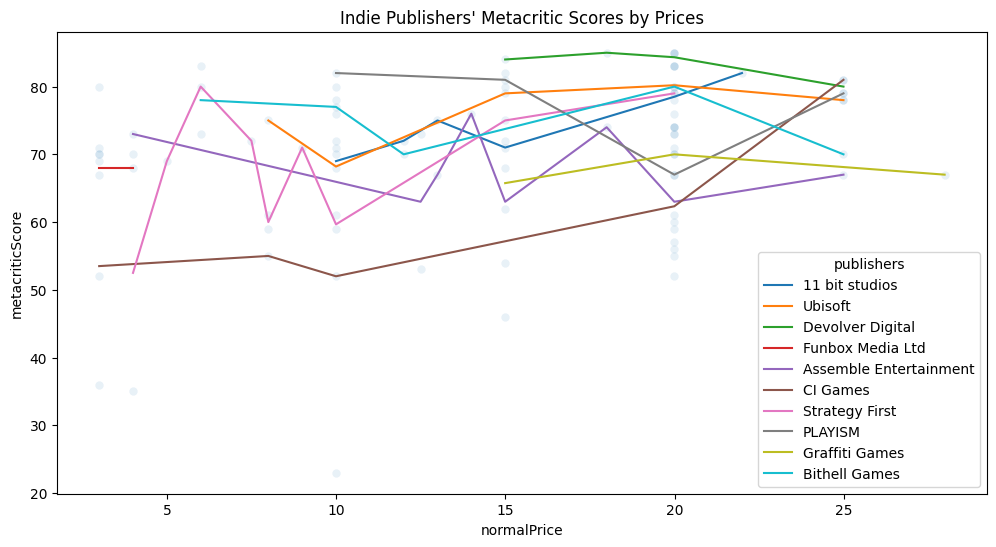

In [15]:
#Metacritic score by the top 10 most common 
#These were not included in the report
pub_counts_aaa = aaa_csv_df['publishers'].value_counts()
pub_counts_indie = indie_csv_df['publishers'].value_counts()

top_pub_counts_aaa = pub_counts_aaa.head(10).index.tolist()
top_pub_counts_indie = pub_counts_indie.head(10).index.tolist()

top_pub_aaa = aaa_csv_df[aaa_csv_df['publishers'].isin(top_pub_counts_aaa)]
top_pub_indie = indie_csv_df[indie_csv_df['publishers'].isin(top_pub_counts_indie)]

plt.figure(figsize=(12,8))
sns.scatterplot(data=top_pub_aaa, x='normalPrice', y='metacriticScore', alpha=0.1)
sns.lineplot(data=top_pub_aaa, x='normalPrice', y='metacriticScore', hue='publishers', errorbar=None)
plt.title("AAA Publishers' Metacritic Scores by Prices")
plt.show()

plt.figure(figsize=(12,6))
sns.scatterplot(data=top_pub_indie, x='normalPrice', y='metacriticScore', alpha=0.1)
sns.lineplot(data=top_pub_indie, x='normalPrice', y='metacriticScore', hue='publishers', errorbar=None)
plt.title("Indie Publishers' Metacritic Scores by Prices")
plt.show()

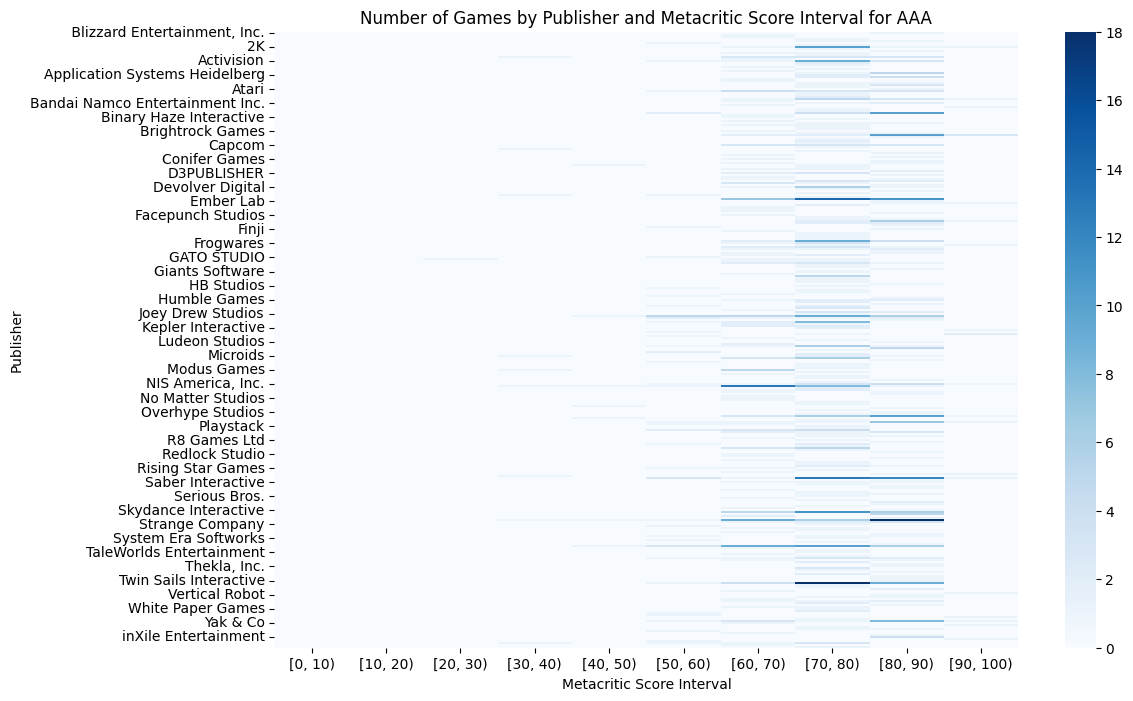

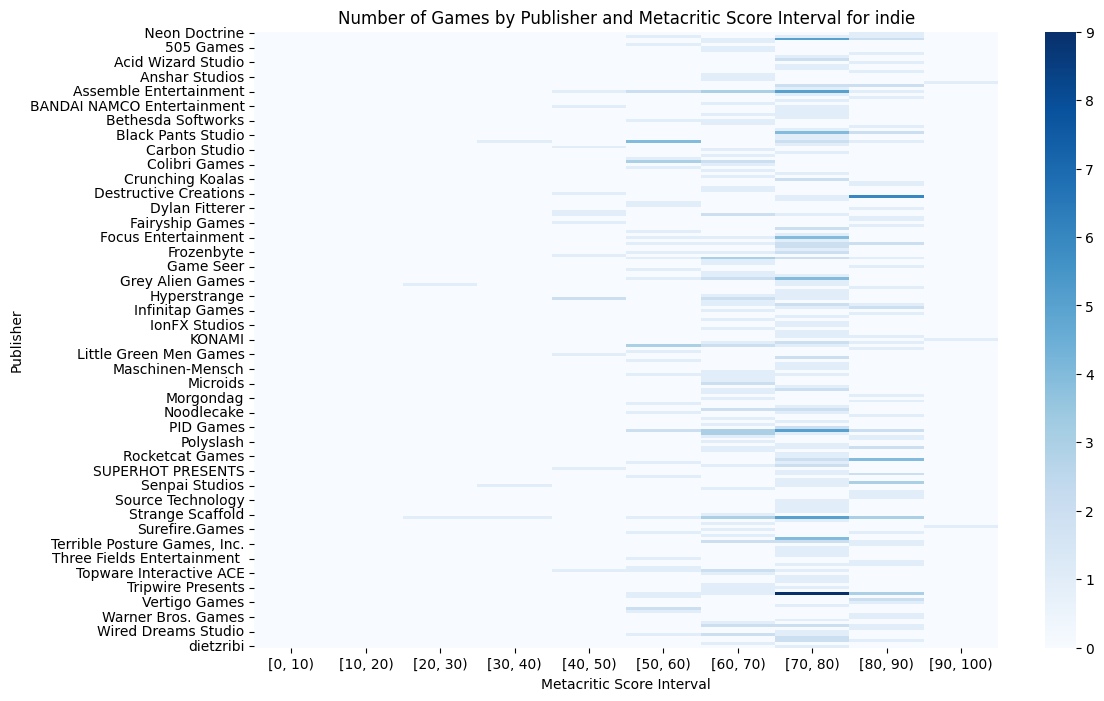

In [16]:
#Heat maps for metacritic stores
def create_heatmap(data, set_name):
    data['metacriticInterval'] = pd.cut(data['metacriticScore'], bins=range(0, 110, 10), right=False)
    heatmap_data = data.pivot_table(index='publishers', columns='metacriticInterval', aggfunc='size', fill_value=0)
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='Blues', fmt='d')
    plt.xlabel('Metacritic Score Interval')
    plt.ylabel('Publisher')
    plt.title(f'Number of Games by Publisher and Metacritic Score Interval for {set_name}')

    plt.show()

create_heatmap(aaa_csv_df, 'AAA')
create_heatmap(indie_csv_df, 'indie')

### Zhanyi Section

In [3]:
import pandas as pd
import requests
# CONTENT WAS NO LONGER USED FOR PROJECT REPORT
def get_reviews(game_id,csv_file):
    # Define the URL for the OpenCritic API, using the game_id parameter
    url = f"https://opencritic-api.p.rapidapi.com/reviews/game/{game_id}"
    
    # Set up the headers for the API request
    headers = {
        "X-RapidAPI-Key": "61206e4cddmshb83e09e46beb28ep1c0a4cjsn8e27fb46a529",
        "X-RapidAPI-Host": "opencritic-api.p.rapidapi.com"
    }
    
    # Make a GET request to the OpenCritic API
    response = requests.get(url, headers=headers)
    
    # Check if the response status code is 200 (OK).
    if response.status_code != 200:
        print(f"Failed to fetch data for game ID {game_id}")
        return

    # Extract data
    data = response.json()
    df = pd.DataFrame(data)
    
    df = pd.DataFrame(data)[['game', 'score','Outlet','Platforms'] ]
    
    df['platform_names'] = df['Platforms'].apply(lambda x: ', '.join([platform['name'] for platform in x if 'name' in platform]))
    
    df['game_name'] = df['game'].apply(lambda x: x['name'])
    
    df['outlet_name'] = df['Outlet'].apply(lambda x: x['name'])
    
    df = df.dropna(subset=['score'])
    df = df[df['score'] != 0]
    df = df[df['platform_names'].str.len() > 0]
    df = df.drop_duplicates(subset='outlet_name')
    df = df.drop_duplicates(subset='platform_names')
    
    # Combine score and platform into a single string
    df['score_outlet'] = df.apply(lambda x: f"Score: {x['score']}, Reviewr: {x['outlet_name']}", axis=1)

    # Pivot the DataFrame
    pivot_df = df.pivot(index='game_name', columns='platform_names', values='score_outlet')
 
    # Dropcolumns to match your data
    if 'PlayStation Vita' in pivot_df.columns:
        pivot_df = pivot_df.drop(columns=['PlayStation Vita'])
    
    # Drop the 'Nintendo Switch' column
    if 'Nintendo Switch' in pivot_df.columns:
        pivot_df = pivot_df.drop(columns=['Nintendo Switch'])
        
    if 'PlayStation 4, Xbox One' in pivot_df.columns:
        pivot_df = pivot_df.drop(columns=['PlayStation 4, Xbox One']) 
        
    if 'PlayStation 4, PC' in pivot_df.columns:
        pivot_df = pivot_df.drop(columns=['PlayStation 4, PC'])   
        
    if 'Nintendo Switch, PC, PlayStation 4' in pivot_df.columns:
        pivot_df = pivot_df.drop(columns=['Nintendo Switch, PC, PlayStation 4'])     
    
    # Rename the 'PS5' column to 'PlayStation'
    if 'PlayStation 5' in pivot_df.columns:
        pivot_df = pivot_df.rename(columns={'PlayStation 5': 'PlayStation'})
      
    if 'Xbox Series X/S' in pivot_df.columns:
        pivot_df = pivot_df.rename(columns={'Xbox Series X/S': 'Xbox'})
        
    if 'Xbox One' in pivot_df.columns:
        pivot_df = pivot_df.rename(columns={'Xbox One': 'Xbox'})
        
    if 'PlayStation 4' in pivot_df.columns:
        pivot_df = pivot_df.rename(columns={'PlayStation 4': 'PlayStation'})
        
    if 'PlayStation 4, Xbox One, PC' in pivot_df.columns:
        pivot_df = pivot_df.rename(columns={'PlayStation 4, Xbox One, PC': 'Xbox'})
    
    if 'PC, PlayStation 4, Xbox One' in pivot_df.columns:
        pivot_df = pivot_df.rename(columns={'PC, PlayStation 4, Xbox One': 'Xbox'})
        
    if 'Xbox One, PlayStation 4, PC' in pivot_df.columns:
        pivot_df = pivot_df.rename(columns={'Xbox One, PlayStation 4, PC': 'Xbox'})
    
    if 'Xbox Series X/S, PlayStation 5, PC' in pivot_df.columns:
        pivot_df = pivot_df.rename(columns={'Xbox Series X/S, PlayStation 5, PC': 'Xbox'})
        
    # Drop one of the duplicate 'Xbox' columns
    # Assuming want to keep the first 'Xbox' column and drop the second
    pivot_df = pivot_df.loc[:, ~pivot_df.columns.duplicated()]
    
    pivot_df = pivot_df[['PC','PlayStation','Xbox']]

      # Append to the existing CSV file, create if doesn't exist

    pivot_df.to_csv(csv_file, mode='a', header=not pd.io.common.file_exists(csv_file))  


In [4]:
# Sample 10 AAA (CONTENT IS NO LONGER USED FOR PROJECT REPORT)
get_reviews(463, 'tem_AAA.csv') # The Witcher 3
get_reviews(12090, 'tem_AAA.csv') # Elden Ring
get_reviews(15855, 'tem_AAA.csv') # Naruto Strom Connection
get_reviews(2851, 'tem_AAA.csv') # The Elder Scrolls V
get_reviews(15847, 'tem_AAA.csv') # Persona 5 Tactica
get_reviews(165, 'tem_AAA.csv') # Assassin's Creed Unity
get_reviews(163, 'tem_AAA.csv') # GTA V
get_reviews(1384, 'tem_AAA.csv') # Devil May Cry 4: SE
get_reviews(1520, 'tem_AAA.csv') # Dark Souls 3
get_reviews(8525, 'tem_AAA.csv') # Cyberpunk 2077

In [5]:
# Sample 10 indie (CONTENT IS NO LONGER USED FOR PROJECT REPORT)
get_reviews(2848, 'tem_indie.csv') # INSIDE
get_reviews(33, 'tem_indie.csv') # Shovel Knight
get_reviews(2242, 'tem_indie.csv') # Stardew Valley
get_reviews(6386, 'tem_indie.csv') # Dead Cells
get_reviews(3046, 'tem_indie.csv') # Overcooked
get_reviews(6225, 'tem_indie.csv') # Overcooked 2
get_reviews(48, 'tem_indie.csv') # Bastion
get_reviews(1558, 'tem_indie.csv') # Hyper Light Drifter
get_reviews(11608, 'tem_indie.csv') # Doki Doki Literature Club
get_reviews(12163, 'tem_indie.csv') # Inscryption 

In [6]:
file_path = 'C:/Users/nasqi/Final141B/STA-141B-Project/tem_AAA.csv'
AAA_df = pd.read_csv(file_path)

In [7]:
AAA_df.head() # NO LONGER USED

,game_name,PC,PlayStation,Xbox
0,The Witcher 3: Wild Hunt,"Score: 92.0, Reviewr: PC Gamer","Score: 100.0, Reviewr: Eurogamer","Score: 93.0, Reviewr: IGN"
1,Elden Ring,"Score: 90.0, Reviewr: PC Gamer","Score: 100.0, Reviewr: IGN Spain","Score: 90.0, Reviewr: IGN Middle East"
2,Naruto X Boruto Ultimate Ninja Storm Connections,"Score: 70, Reviewr: SpaceNerd.it","Score: 60, Reviewr: GamingTrend","Score: 69, Reviewr: Bazimag"
3,The Elder Scrolls V: Skyrim - Special Edition,"Score: 70.0, Reviewr: Areajugones","Score: 80.0, Reviewr: Metro GameCentral","Score: 80.0, Reviewr: USgamer"
4,Persona 5 Tactica,"Score: 60.0, Reviewr: VideoGamer","Score: 90.0, Reviewr: NookGaming","Score: 70.0, Reviewr: Shacknews"


In [3]:
path = 'C:/Users/nasqi/Final141B/STA-141B-Project/tem_indie.csv'
indie_df = pd.read_csv(path)

In [4]:
indie_df.head() # NO LONGER USED

,game_name,PC,PlayStation,Xbox
0,INSIDE,"Score: 76, Reviewr: PC Gamer","Score: 80, Reviewr: Metro GameCentral","Score: 80, Reviewr: Eurogamer"
1,Shovel Knight,"Score: 70, Reviewr: Eurogamer","Score: 90, Reviewr: Attack of the Fanboy","Score: 80, Reviewr: Metro GameCentral"
2,Stardew Valley,"Score: 80.0, Reviewr: PC Gamer","Score: 90.0, Reviewr: TheSixthAxis","Score: 88.0, Reviewr: IGN"
3,Dead Cells,"Score: 90.0, Reviewr: PC Gamer","Score: 80.0, Reviewr: Metro GameCentral","Score: 90.0, Reviewr: IGN Spain"
4,Overcooked,"Score: 86.0, Reviewr: PC Gamer","Score: 80.0, Reviewr: Eurogamer","Score: 83.0, Reviewr: Game Informer"


In [5]:
def get_review_summary(appid): # CODE BELOW WAS USED TO ADD TO FINAL DATASET
    url = f"https://store.steampowered.com/appreviews/{appid}?json=1&filter=summary"
    response = requests.get(url)
    data = response.json()

    total_reviews = data['query_summary']['total_reviews']
    positive_reviews = data['query_summary']['total_positive']
    negative_reviews = data['query_summary']['total_negative']

    return total_reviews, positive_reviews, negative_reviews


In [7]:
update_aaa_set = pd.read_csv('C:/Users/nasqi/141B/STA-141B-Project/aaa_set.csv')

In [8]:
update_aaa_set.head()

,title,steamAppID,releaseDate,normalPrice,metacriticScore,steamRatingText,steamRatingPercent,developers,publishers
0,Creed: Rise to Glory,804490,2018-09-25,29.99,84,Very Positive,80,Survios,Survios
1,My Time At Portia,666140,2019-01-15,29.99,73,Very Positive,92,Pathea Games,Focus Entertainment
2,Mr. DRILLER DrillLand,1126750,2020-06-25,29.99,76,Very Positive,82,"INFINITY Co., Ltd.",BANDAI NAMCO Entertainment
3,The Elder Scrolls V: Skyrim VR,611670,2018-04-02,59.99,81,Mostly Positive,74,Bethesda Game Studios,Bethesda Softworks
4,Dying Light,239140,2015-01-27,49.99,75,Overwhelmingly Positive,95,Techland,Techland


In [9]:
# Fetch and store review data
review_data = update_aaa_set['steamAppID'].apply(lambda x: pd.Series(get_review_summary(x)))
review_data.columns = ['total_reviews', 'positive_reviews', 'negative_reviews']
update_aaa_set = pd.concat([update_aaa_set, review_data], axis=1)

# Now df has the total, positive, and negative reviews for each game

In [10]:
update_aaa_set.head()

,title,steamAppID,releaseDate,normalPrice,metacriticScore,steamRatingText,steamRatingPercent,developers,publishers,total_reviews,positive_reviews,negative_reviews
0,Creed: Rise to Glory,804490,2018-09-25,29.99,84,Very Positive,80,Survios,Survios,947,734,213
1,My Time At Portia,666140,2019-01-15,29.99,73,Very Positive,92,Pathea Games,Focus Entertainment,11234,10409,825
2,Mr. DRILLER DrillLand,1126750,2020-06-25,29.99,76,Very Positive,82,"INFINITY Co., Ltd.",BANDAI NAMCO Entertainment,76,66,10
3,The Elder Scrolls V: Skyrim VR,611670,2018-04-02,59.99,81,Mostly Positive,74,Bethesda Game Studios,Bethesda Softworks,6124,4568,1556
4,Dying Light,239140,2015-01-27,49.99,75,Overwhelmingly Positive,95,Techland,Techland,75539,71174,4365


In [11]:
update_indie_set = pd.read_csv('C:/Users/nasqi/141B/STA-141B-Project/indie_set.csv')

In [12]:
update_indie_set.head()

,title,steamAppID,releaseDate,normalPrice,metacriticScore,steamRatingText,steamRatingPercent,developers,publishers
0,Anomaly Defenders,294750,2014-05-29,9.99,70,Mostly Positive,75,11 bit studios,11 bit studios
1,Monster Energy Supercross - The Official Video...,1089830,2020-02-04,24.99,72,Very Positive,88,Milestone S.r.l.,Milestone S.r.l.
2,Legends of Eisenwald,246760,2014-07-21,19.99,71,Mostly Positive,76,Aterdux Entertainment,Aterdux Entertainment
3,SPACECOM,263860,2014-09-17,9.99,68,Mixed,65,Flow Combine,11 bit studios
4,Trials Evolution: Gold Edition,220160,2013-03-21,19.99,85,Mostly Positive,75,Redlynx Ltd,Ubisoft


In [13]:
# Fetch and store review data
review_data = update_indie_set['steamAppID'].apply(lambda x: pd.Series(get_review_summary(x)))
review_data.columns = ['total_reviews', 'positive_reviews', 'negative_reviews']
update_indie_set = pd.concat([update_indie_set, review_data], axis=1)

# Now df has the total, positive, and negative reviews for each game

In [14]:
update_indie_set.head()

,title,steamAppID,releaseDate,normalPrice,metacriticScore,steamRatingText,steamRatingPercent,developers,publishers,total_reviews,positive_reviews,negative_reviews
0,Anomaly Defenders,294750,2014-05-29,9.99,70,Mostly Positive,75,11 bit studios,11 bit studios,145,99,46
1,Monster Energy Supercross - The Official Video...,1089830,2020-02-04,24.99,72,Very Positive,88,Milestone S.r.l.,Milestone S.r.l.,590,512,78
2,Legends of Eisenwald,246760,2014-07-21,19.99,71,Mostly Positive,76,Aterdux Entertainment,Aterdux Entertainment,442,296,146
3,SPACECOM,263860,2014-09-17,9.99,68,Mixed,65,Flow Combine,11 bit studios,85,56,29
4,Trials Evolution: Gold Edition,220160,2013-03-21,19.99,85,Mostly Positive,75,Redlynx Ltd,Ubisoft,1338,970,368


In [21]:
len(update_aaa_set)

923

In [20]:
len(update_indie_set)

407

In [22]:
update_aaa_set.to_csv('update_aaa_set.csv', index=False)
update_indie_set.to_csv('update_indie_set.csv', index=False)